In [167]:
import numpy as np
import pandas as pd
import math, datetime
import matplotlib.pyplot as plt
from tqdm import tqdm
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from mpl_toolkits.mplot3d import Axes3D
from sklearn.metrics import mean_squared_error

### Dataset with phones reviews from Amazon: https://www.kaggle.com/grikomsn/amazon-cell-phones-reviews

### Model development is based on article: https://www.kaggle.com/viniciuscleves/anime-recomendation-based-on-user-clustering

In [3]:
items = pd.read_csv('20191226-items.csv')
items = items[['asin', 'brand', 'rating', 'totalReviews', 'price', 'originalPrice']]
items.rename(columns={'totalReviews': 'total_reviews', 'originalPrice': 'original_price'}, inplace=True)
print('items sample size: {}'.format(items.shape[0]))
items.head()

items sample size: 720


,asin,brand,rating,total_reviews,price,original_price
0,B0000SX2UC,NaN,3.0,14,0.00,0.0
1,B0009N5L7K,Motorola,3.0,7,49.95,0.0
2,B000SKTZ0S,Motorola,2.7,22,99.99,0.0
3,B001AO4OUC,Motorola,3.3,21,0.00,0.0
4,B001DCJAJG,Motorola,3.1,12,149.99,0.0


Some histograms (Maybe it's not bad to put some other comments here)

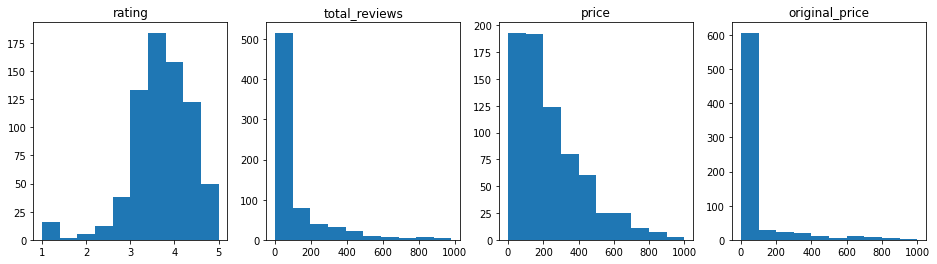

In [4]:
fig, axs = plt.subplots(1, 4, figsize=(16, 4))
for i, col in enumerate(items.columns[2:]):
    axs[i].hist(items[col])
    axs[i].set_title(col)

In [5]:
reviews = pd.read_csv('20191226-reviews.csv')
reviews.rename(columns={'helpfulVotes': 'helpful_votes'}, inplace=True)
print('reviews sample size: {}'.format(reviews.shape[0]))
reviews.head()

reviews sample size: 67986


,asin,name,rating,date,verified,title,body,helpful_votes
0,B0000SX2UC,Janet,3,"October 11, 2005",False,"Def not best, but not worst",I had the Samsung A600 for awhile which is abs...,1.0
1,B0000SX2UC,Luke Wyatt,1,"January 7, 2004",False,Text Messaging Doesn't Work,Due to a software issue between Nokia and Spri...,17.0
2,B0000SX2UC,Brooke,5,"December 30, 2003",False,Love This Phone,"This is a great, reliable phone. I also purcha...",5.0
3,B0000SX2UC,amy m. teague,3,"March 18, 2004",False,"Love the Phone, BUT...!","I love the phone and all, because I really did...",1.0
4,B0000SX2UC,tristazbimmer,4,"August 28, 2005",False,"Great phone service and options, lousy case!",The phone has been great for every purpose it ...,1.0


In [6]:
def to_date(x):
    months = {
        'January': 1, 'February': 2, 'March': 3, 'April': 4, 'May': 5, 'June': 6, 'July': 7,
        'August': 8, 'September': 9, 'October': 10, 'November': 11, 'December': 12
    }
    date_list = x.split(' ')
    month = int(months[date_list[0]])
    day = int(date_list[1].replace(',', ''))
    year = int(date_list[2])
    return datetime.datetime(year, month, day)

reviews.date = reviews.date.apply(to_date)
reviews.head()

,asin,name,rating,date,verified,title,body,helpful_votes
0,B0000SX2UC,Janet,3,2005-10-11,False,"Def not best, but not worst",I had the Samsung A600 for awhile which is abs...,1.0
1,B0000SX2UC,Luke Wyatt,1,2004-01-07,False,Text Messaging Doesn't Work,Due to a software issue between Nokia and Spri...,17.0
2,B0000SX2UC,Brooke,5,2003-12-30,False,Love This Phone,"This is a great, reliable phone. I also purcha...",5.0
3,B0000SX2UC,amy m. teague,3,2004-03-18,False,"Love the Phone, BUT...!","I love the phone and all, because I really did...",1.0
4,B0000SX2UC,tristazbimmer,4,2005-08-28,False,"Great phone service and options, lousy case!",The phone has been great for every purpose it ...,1.0


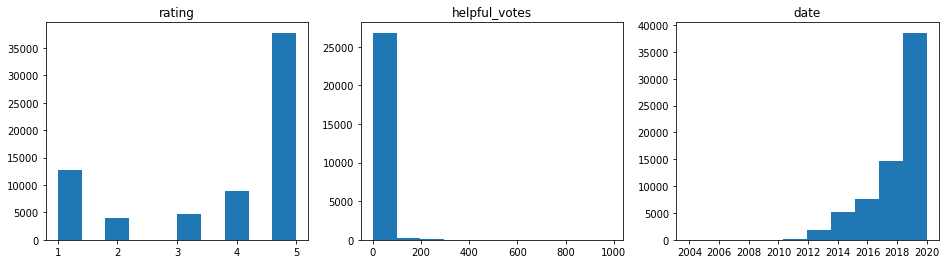

In [46]:
fig, axs = plt.subplots(1, 3, figsize=(16, 4))
for i, col in enumerate(['rating', 'helpful_votes', 'date']):
    axs[i].hist(reviews[col])
    axs[i].set_title(col)

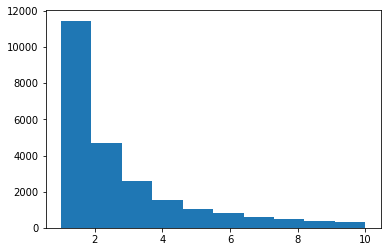

In [8]:
_ = plt.hist(reviews.loc[reviews.helpful_votes<=10, 'helpful_votes'])

### User-based model

Selecting cumstomers, who has n (n = MIN_REVIEW_NUM) and more reviews, verified reviews

In [212]:
reviews1 = reviews[reviews.verified==True]

MIN_REVIEW_NUM = 2
pvt = reviews1.groupby(['name']).count().reset_index() # 'count' is not nice, topic for codereview
csm_list = pvt[pvt.asin>=MIN_REVIEW_NUM].name.tolist()

# cusomter has 2 and more reviews
reviews1 = reviews[(reviews.name.isin(csm_list))]
print('sample length: {}'.format(reviews1.shape[0]))

sample length: 25226


rf (user Review Frequency) - sample with average time between 2 reviews (td) and average review rating (rating).
Is used to plot distribution of ratings in context of user reviews frequency.

In [131]:
def func(x):
    x['td'] = (x.date-x.prev_date)/datetime.timedelta(1)
    return x

reviews1 = reviews1.assign(prev_date=reviews1[['name', 'date']].sort_values('date').groupby('name').shift(1))
reviews1 = reviews1.apply(func, axis=1)
rf = reviews1.loc[reviews1.td.isnull()==False, ['name', 'td']].groupby('name').mean().reset_index()
mr = reviews1[['name', 'rating']].groupby('name').mean().reset_index()
rf = rf.join(mr.set_index('name'), on='name')

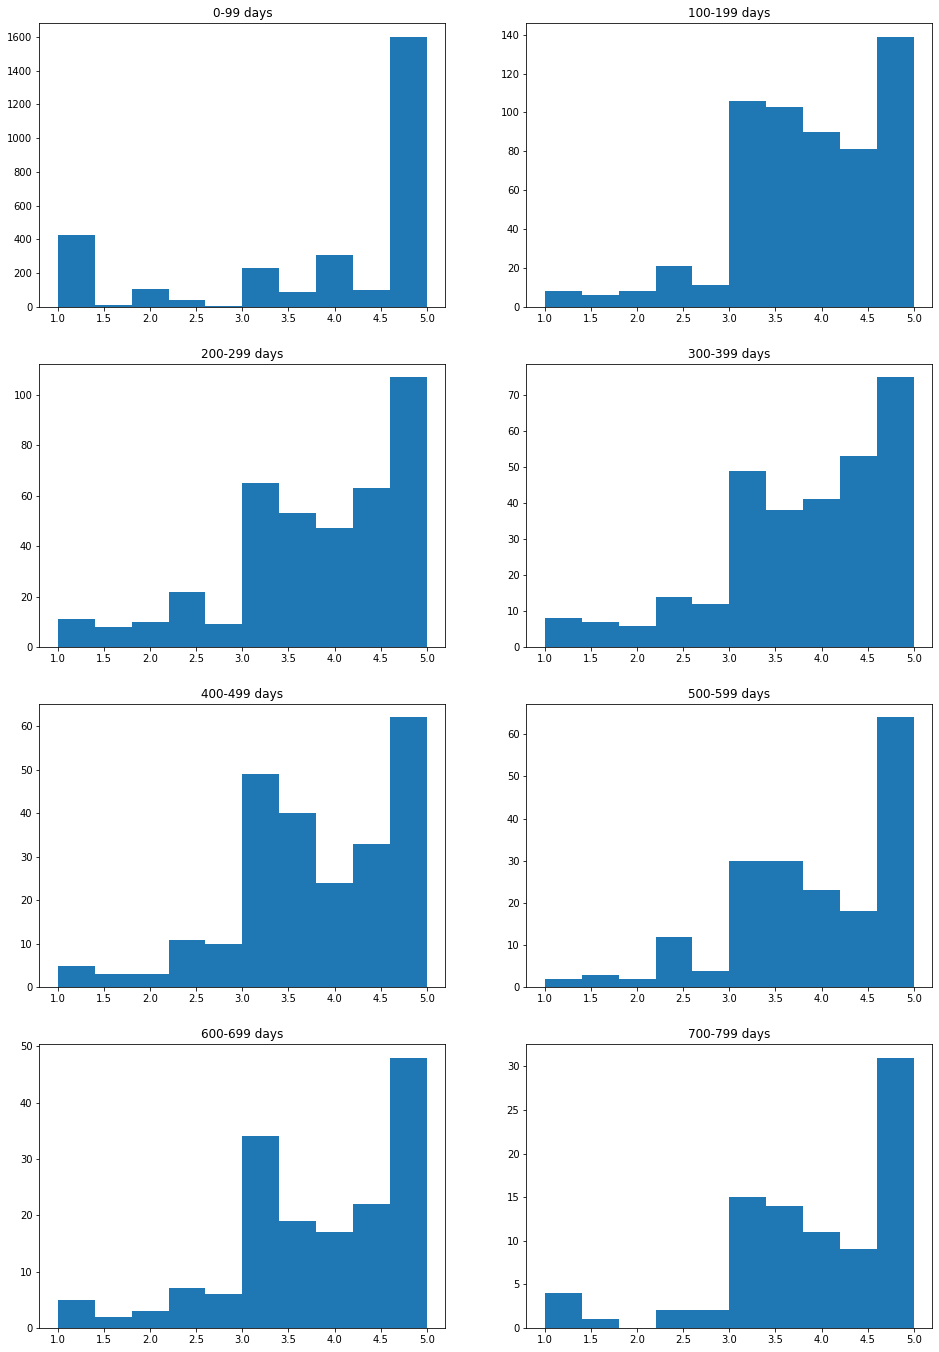

In [132]:
BIN_SIZE = 100
MAX_PLOT_ROWS = 4

rf = rf.assign(td_bin=rf.td.apply(lambda x: int(x/BIN_SIZE)))
l = len(rf.td_bin.unique())
bins = {i: '{}-{} days'.format(i*BIN_SIZE, (i+1)*BIN_SIZE-1) for i in range(l)}

rows = min(l//2+l%2, MAX_PLOT_ROWS)
fig, axs = plt.subplots(rows, 2, figsize=(16, 6*(rows)))
for i in range(rows*2):
    axs[i//2][i%2].hist(rf.loc[rf.td_bin==i, 'rating'])
    axs[i//2][i%2].set_title(bins[i])

In [134]:
rf1 = rf[['name', 'td']]
rf1.rename(columns=({'td': 'mean_td'}), inplace=True)
reviews1 = reviews1.join(rf1.set_index('name'), on='name')
reviews1 = reviews1[reviews1.mean_td>=200]

/usr/local/lib/python3.8/site-packages/pandas/core/frame.py:4293: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().rename(


Merging brand name instead off asin number, dropping rows with unplugged brand

In [213]:
reviews1 = reviews1[['name', 'asin', 'rating']].join(items[['asin', 'brand']].set_index('asin'), on='asin')
reviews1 = reviews1[reviews1.brand.isnull()==False]
reviews1.drop(['asin'], axis='columns', inplace=True)
print('sample length: {}'.format(reviews1.shape[0]))
reviews1.head()

sample length: 25171


,name,rating,brand
15,William B.,4,Motorola
21,Thomas,4,Motorola
23,Kristy,1,Motorola
27,Amazon Customer,1,Motorola
39,Linda,4,Motorola


Extracting a feature vector for each brand

In [214]:
# spand brand in columns, one for each brand
def func(x):
    x[x.brand] = 1
    return x

reviews1 = reviews1.apply(func, axis=1)
reviews1.drop(['brand'], axis='columns', inplace=True)
reviews1.head()

,ASUS,Apple,Google,HUAWEI,Motorola,Nokia,OnePlus,Samsung,Sony,Xiaomi,name,rating
15,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,William B.,4
21,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,Thomas,4
23,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,Kristy,1
27,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,Amazon Customer,1
39,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,Linda,4


Setting rating value instead of flags

In [215]:
cols = reviews1.columns.tolist()
for col in ['name', 'rating']:
    cols.remove(col)

reviews1[cols] = reviews1[cols].mul(reviews1['rating'], axis=0)
reviews1.drop(['rating'], axis='columns', inplace=True)
reviews1.head()

,ASUS,Apple,Google,HUAWEI,Motorola,Nokia,OnePlus,Samsung,Sony,Xiaomi,name
15,NaN,NaN,NaN,NaN,4.0,NaN,NaN,NaN,NaN,NaN,William B.
21,NaN,NaN,NaN,NaN,4.0,NaN,NaN,NaN,NaN,NaN,Thomas
23,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,Kristy
27,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,Amazon Customer
39,NaN,NaN,NaN,NaN,4.0,NaN,NaN,NaN,NaN,NaN,Linda


Customers have reviews of phones with same brand. So it is needed to calculate mean value of rating in reviews of phones with same brands from one customer

In [216]:
reviews1 = reviews1.groupby(['name']).mean()
print('sample length: {}'.format(reviews1.shape[0]))
reviews1.head()

sample length: 5380


,ASUS,Apple,Google,HUAWEI,Motorola,Nokia,OnePlus,Samsung,Sony,Xiaomi
name,,,,,,,,,,
#AmazonCustomer,NaN,NaN,3.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
.,NaN,NaN,NaN,NaN,NaN,2.0,NaN,1.0,NaN,NaN
0,NaN,NaN,NaN,NaN,NaN,3.0,NaN,5.0,NaN,NaN
12TreW,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,1.0
16Paws,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5.0,NaN,NaN


In [217]:
reviews1 = reviews1.fillna(value=0)
reviews1.head()

,ASUS,Apple,Google,HUAWEI,Motorola,Nokia,OnePlus,Samsung,Sony,Xiaomi
name,,,,,,,,,,
#AmazonCustomer,0.0,0.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
.,0.0,0.0,0.0,0.0,0.0,2.0,0.0,1.0,0.0,0.0
0,0.0,0.0,0.0,0.0,0.0,3.0,0.0,5.0,0.0,0.0
12TreW,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0
16Paws,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5.0,0.0,0.0


In [218]:
border = int(0.7*reviews1.shape[0])

train_data = reviews1[:border]
test_data = reviews1[border:]

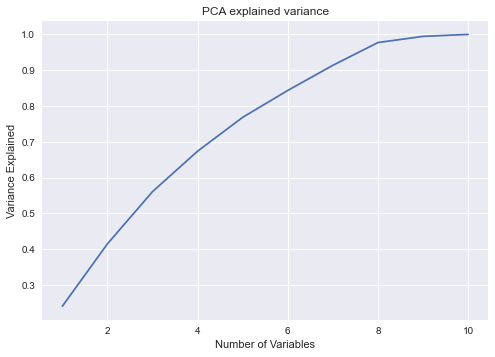

In [219]:
pca = PCA()
pca.fit(train_data)
acc_var = np.cumsum(pca.explained_variance_ratio_) 

plt.style.use('seaborn')
plt.plot(range(1, len(acc_var)+1), acc_var)
plt.title('PCA explained variance')
plt.xlabel('Number of Variables')
_ = plt.ylabel('Variance Explained')

In [220]:
number_of_components = 8
pca.set_params(n_components=number_of_components)
pca.fit(train_data)
train_data_pca = pca.transform(train_data)
train_data_pos_pca = pd.DataFrame(train_data_pca)
train_data_pos_pca['name'] = train_data.index
train_data_pos_pca = train_data_pos_pca.set_index('name')
train_data_pos_pca.head()

,0,1,2,3,4,5,6,7
name,,,,,,,,
#AmazonCustomer,1.932634,-1.550800,-0.087674,-1.544709,1.135260,2.295009,-1.250735,0.059627
.,0.922245,-1.251541,-0.025263,-0.997946,1.534690,-1.179878,-0.673594,-0.076272
0,-2.520847,0.335975,0.103006,0.446027,1.839039,-1.518106,-0.877389,-0.597305
12TreW,1.167700,-1.651027,-0.872911,-0.549663,-0.038026,-0.174956,-0.108341,0.159098
16Paws,-2.654427,-0.715605,-0.124148,0.348280,-0.247265,0.025118,0.010243,-0.067775


100%|██████████| 98/98 [00:37<00:00,  2.64it/s]


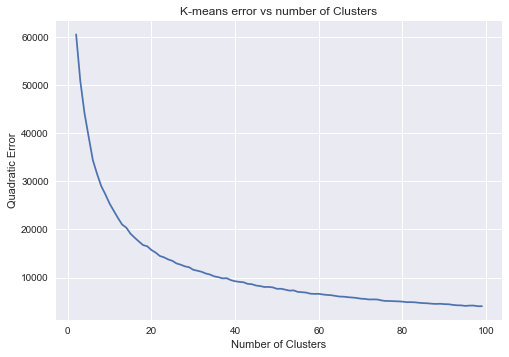

In [221]:
inertia = []
scores = []
for n_clusters in tqdm(range(2, 100)):
    kmeans = KMeans(n_clusters=n_clusters)
    kmeans.fit(train_data_pca)
    inertia.append(kmeans.inertia_)
plt.plot(range(2, 100), inertia)
plt.xlabel('Number of Clusters')
plt.ylabel('Quadratic Error')
_ = plt.title('K-means error vs number of Clusters')

In [222]:
#project the users feature vector in 3 dimensions
reviews_with_label = pd.DataFrame(PCA(n_components=3).fit_transform(train_data))
reviews_with_label['name'] = train_data.index
reviews_with_label = reviews_with_label.set_index('name')

#find each user's cluster
kmeans = KMeans(n_clusters=10, n_init=30)
train_data_with_label = train_data.assign(label=kmeans.fit_predict(train_data_pos_pca))
reviews_with_label.label = train_data_with_label.label
train_data_with_label.head()

<ipython-input-222-855567f387ce>:9: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  reviews_with_label.label = train_data_with_label.label


,ASUS,Apple,Google,HUAWEI,Motorola,Nokia,OnePlus,Samsung,Sony,Xiaomi,label
name,,,,,,,,,,,
#AmazonCustomer,0.0,0.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
.,0.0,0.0,0.0,0.0,0.0,2.0,0.0,1.0,0.0,0.0,7
0,0.0,0.0,0.0,0.0,0.0,3.0,0.0,5.0,0.0,0.0,8
12TreW,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,7
16Paws,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5.0,0.0,0.0,1


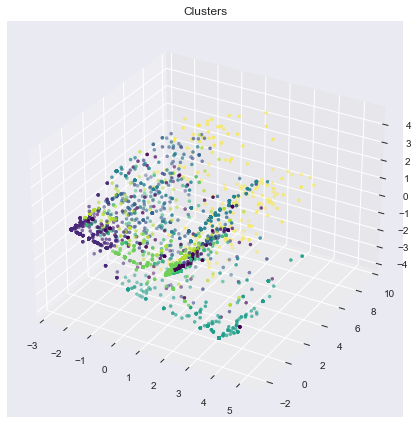

In [223]:
fig = plt.figure()
ax = Axes3D(fig)

ax.scatter(
    reviews_with_label[0], reviews_with_label[1], reviews_with_label[2],
    c=reviews_with_label.label, cmap='viridis', s=10
)
_ = plt.title('Clusters')

Distribution of customers number in clusters

In [224]:
print('Cluster ID     Number of users in cluster')
for idx, val in (pd.get_dummies(reviews_with_label.label)).sum().iteritems():
    print(f'{idx}              {val}')

Cluster ID     Number of users in cluster
0              204
1              1236
2              158
3              321
4              385
5              405
6              178
7              500
8              214
9              164


In [225]:
train_data_with_label = train_data_with_label.reset_index()
train_data_with_label.head()

,name,ASUS,Apple,Google,HUAWEI,Motorola,Nokia,OnePlus,Samsung,Sony,Xiaomi,label
0,#AmazonCustomer,0.0,0.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
1,.,0.0,0.0,0.0,0.0,0.0,2.0,0.0,1.0,0.0,0.0,7
2,0,0.0,0.0,0.0,0.0,0.0,3.0,0.0,5.0,0.0,0.0,8
3,12TreW,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,7
4,16Paws,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5.0,0.0,0.0,1


In [226]:
for col in train_data_with_label.columns[1:-1]:
    train_data_with_label.loc[train_data_with_label[col]==0, col] = np.nan
train_data_with_label.head()

,name,ASUS,Apple,Google,HUAWEI,Motorola,Nokia,OnePlus,Samsung,Sony,Xiaomi,label
0,#AmazonCustomer,NaN,NaN,3.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0
1,.,NaN,NaN,NaN,NaN,NaN,2.0,NaN,1.0,NaN,NaN,7
2,0,NaN,NaN,NaN,NaN,NaN,3.0,NaN,5.0,NaN,NaN,8
3,12TreW,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,1.0,7
4,16Paws,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5.0,NaN,NaN,1


In [227]:
cols = train_data_with_label.columns[1:]
rm = train_data_with_label[cols].groupby(['label']).mean().reset_index()
rm

,label,ASUS,Apple,Google,HUAWEI,Motorola,Nokia,OnePlus,Samsung,Sony,Xiaomi
0,0,4.0,3.679688,4.704902,3.821429,2.927477,2.717391,4.500000,3.726295,3.571429,4.034483
1,1,3.4,1.655405,1.578947,1.933333,1.189922,1.256410,4.000000,4.574181,1.615385,2.500000
2,2,3.0,3.507576,2.491228,4.813291,3.259434,3.262626,3.571429,4.057644,3.385417,3.674242
3,3,3.0,3.127132,2.121622,1.333333,4.643510,2.500000,4.000000,3.853284,1.950000,4.045977
4,4,5.0,4.754329,2.250000,3.428571,3.342473,3.173611,5.000000,3.766109,2.875000,3.142857
5,5,4.0,3.814516,2.000000,3.937500,3.504630,3.075000,5.000000,3.566515,3.761905,4.750000
6,6,NaN,2.812500,3.090909,3.666667,3.370833,3.344828,5.000000,3.722727,4.658240,4.188889
7,7,2.5,1.115789,1.333333,2.388889,1.885714,1.983871,4.666667,1.345274,1.281250,1.285714
8,8,2.5,2.660317,2.547619,2.333333,3.413056,4.544393,4.750000,4.006767,2.375000,2.725490
9,9,3.3,3.985440,3.687005,4.424326,4.144100,3.926048,4.319746,3.968467,4.098991,4.487837


In [228]:
td = test_data.reset_index()
td = td.assign(label=pd.DataFrame({'l': kmeans.predict(pca.transform(test_data))}))
td.head()

,name,ASUS,Apple,Google,HUAWEI,Motorola,Nokia,OnePlus,Samsung,Sony,Xiaomi,label
0,S.,0.0,0.0,0.0,0.0,2.5,0.0,0.0,0.0,0.0,1.0,7
1,S. Bickley,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0,0.0,0.0,1
2,S. Brown,0.0,1.0,0.0,0.0,0.0,0.0,0.0,4.0,0.0,0.0,1
3,S. J. Shaff,0.0,0.0,0.0,0.0,2.5,0.0,0.0,0.0,0.0,0.0,7
4,S. Jones,0.0,0.0,0.0,0.0,4.0,0.0,0.0,3.5,0.0,0.0,3


In [229]:
def predict_ratings(x):
    for col in rm.columns[1:]:
        x['p_{}'.format(col)] = rm.loc[x.label, col]
    return x

td = td.apply(predict_ratings, axis=1)
td.to_csv('test_data.csv')
td.head()

,name,ASUS,Apple,Google,HUAWEI,Motorola,Nokia,OnePlus,Samsung,Sony,...,p_ASUS,p_Apple,p_Google,p_HUAWEI,p_Motorola,p_Nokia,p_OnePlus,p_Samsung,p_Sony,p_Xiaomi
0,S.,0.0,0.0,0.0,0.0,2.5,0.0,0.0,0.0,0.0,...,2.5,1.115789,1.333333,2.388889,1.885714,1.983871,4.666667,1.345274,1.281250,1.285714
1,S. Bickley,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0,0.0,...,3.4,1.655405,1.578947,1.933333,1.189922,1.256410,4.000000,4.574181,1.615385,2.500000
2,S. Brown,0.0,1.0,0.0,0.0,0.0,0.0,0.0,4.0,0.0,...,3.4,1.655405,1.578947,1.933333,1.189922,1.256410,4.000000,4.574181,1.615385,2.500000
3,S. J. Shaff,0.0,0.0,0.0,0.0,2.5,0.0,0.0,0.0,0.0,...,2.5,1.115789,1.333333,2.388889,1.885714,1.983871,4.666667,1.345274,1.281250,1.285714
4,S. Jones,0.0,0.0,0.0,0.0,4.0,0.0,0.0,3.5,0.0,...,3.0,3.127132,2.121622,1.333333,4.643510,2.500000,4.000000,3.853284,1.950000,4.045977


In [230]:
for name in (td.columns[1:11]):
    y_true = td.loc[(td[name]>0) & (td['p_'+name].isnull()==False), name]
    y_pred = td.loc[(td[name]>0) & (td['p_'+name].isnull()==False), 'p_'+name]
    print('{}: {}'.format(name, str(mean_squared_error(y_true, y_pred))))

ASUS: 3.0971428571428574
Apple: 0.98039605258607
Google: 1.1255769882277267
HUAWEI: 0.953526503195019
Motorola: 1.0804444050643789
Nokia: 1.2937527340928554
OnePlus: 3.4612513901557116
Samsung: 0.8532823677570311
Sony: 0.6739193186990808
Xiaomi: 0.796287040804612


In [201]:
for name in (td.columns[1:11]):
    if td.loc[td[name].isnull()].shape[0]>0:
        print(name)

In [198]:
np.nan > 0

False

In [190]:
mean_squared_error(y_true, y_pred)

0.5867129094831764

In [208]:
td[td['ASUS']>0][['name', 'ASUS', 'p_ASUS']]

,name,ASUS,p_ASUS
69,ShoppyG,3.0,1.666667
100,Steven C,1.0,NaN
123,TM,5.0,5.000000
132,Tanner S.,5.0,2.333333
237,alex,1.0,NaN
325,dp,2.0,5.000000


In [211]:
train = train_data.reset_index()
train.loc[train.ASUS>0, ['name', 'ASUS']]

,name,ASUS
43,Adan,4.0
79,Allen,5.0
329,Curt,1.0
361,Dana,5.0
375,Danny,5.0
384,David B.,3.0
514,FEH,2.0
558,Gavin,1.0
600,Hal,2.0
756,JoeBA - LU1ARV,2.0


In [210]:
train_data.head()

,ASUS,Apple,Google,HUAWEI,Motorola,Nokia,OnePlus,Samsung,Sony,Xiaomi
name,,,,,,,,,,
.,0.0,0.0,0.0,0.0,0.0,2.0,0.0,1.000000,0.0,0.0
0,0.0,0.0,0.0,0.0,0.0,3.0,0.0,5.000000,0.0,0.0
40 - 40,0.0,0.0,0.0,0.0,0.0,5.0,0.0,0.000000,0.0,0.0
:),0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.666667,0.0,0.0
A B,0.0,0.0,0.0,0.0,5.0,0.0,0.0,0.000000,1.0,0.0
